<a href="https://colab.research.google.com/github/mauriciodev/spatialgeodesy/blob/main/notebooks/Orbitas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description

This notebook illustrates the difference between the navigation data broadcasted by the GNSS and the precise ephemeris data distributed by IGS and NGA. We also compare the kepplerian 

# Preparation

## Installing dependencies

In [ ]:
#Imported libraries
import os
import numpy as np
from numpy import *
#from math import *
import xarray
import matplotlib.pyplot as plt

In [ ]:
#Installing the package that reads rinex and sp3 files
!pip install georinex
import georinex as gr

     |████████████████████████████████| 50 kB 3.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for georinex: filename=georinex-1.15.1-py3-none-any.whl size=52018 sha256=7cb33c09614b34db5b83af102e38c585494774fde8e32ec08ccc15fa2a323ad4
  Stored in directory: /root/.cache/pip/wheels/fa/f5/f3/a0b697b437e10561fb6a4546e3d5c4cc5fb073fe746dddd04c
Successfully built georinex


## Input files

In [ ]:
#CHANGE THIS TO use other dates. This is the reference date that is going to be used to download the navigation and precise ephemeris files.
t=np.datetime64('2021-05-30T23:45:00') 

In [ ]:
#Date time processing
print("Time: ",t)
today=t.astype('datetime64[D]')
secsOfDay=(t-today)/ np.timedelta64(1, 's')
print("Seconds of day:" , secsOfDay)
#dayOfWeek=(t.astype('datetime64[D]').view('int64') - 3) % 7
gps_t0=np.datetime64('1980-01-06T00:00:00')
gpsWeek=((t - gps_t0)/ np.timedelta64(1, 'D')/7).astype(int64)
print("GPS week", gpsWeek)
dayOfWeek=((t - gps_t0)/ np.timedelta64(1, 'D') % 7).astype(int64)
print("Day of GPS week:", dayOfWeek)
year=t.astype('datetime64[Y]')
dayOfYear=((t-year)/np.timedelta64(1,'D')+1).astype(int64)
print("Day of year:",dayOfYear)
secsOfWeek=secsOfDay+dayOfWeek*24*60*60
print("Seconds of week:",secsOfWeek)
twoDigitYear=year.astype(int)-30
print("Year with two digits:",twoDigitYear)

Time:  2021-05-30T23:45:00
Seconds of day: 85500.0
GPS week 2160
Day of GPS week: 0
Day of year: 150
Seconds of week: 85500.0
Year with two digits: 21


In [ ]:
#PLEASE CHANGE THE FILE HERE TO USE OTHER DOWNLOAD LINKS

#File name is based on the GPS week and day of week.
#precise_orbits_url="ftp://ftp.nga.mil/pub2/gps/pedata/{2}pe/nga{0}{1}.eph".format(gpsWeek,dayOfWeek,year)
precise_orbits_url="https://igs.bkg.bund.de/root_ftp/IGS/products/orbits/{0}/cod{0:04}{1}.eph_r.Z".format(gpsWeek,dayOfWeek)

#File name is based on the Day of Year
navigation_file_url="ftp://ftp.nga.mil/pub2/gps/navdata/2021/NGA_{0:03}a.{1:02}n".format(dayOfYear,twoDigitYear)

## Downloading the SP3 precise coordinates file 


In [ ]:
#splitting the file name from the URL
sp3File=os.path.split(precise_orbits_url)[1]
!wget $precise_orbits_url -O $sp3File
!uncompress -f $sp3File #uncompress from .Z
sp3File=sp3File[:-2] #removing the .Z from filename

--2021-10-18 19:39:33--  https://igs.bkg.bund.de/root_ftp/IGS/products/orbits/2160/cod21600.eph_r.Z
Resolving igs.bkg.bund.de (igs.bkg.bund.de)... 141.74.33.23
Connecting to igs.bkg.bund.de (igs.bkg.bund.de)|141.74.33.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 194115 (190K) [application/x-compress]
Saving to: ‘cod21600.eph_r.Z’

cod21600.eph_r.Z    100%[===================>] 189.57K   696KB/s    in 0.3s    

2021-10-18 19:39:34 (696 KB/s) - ‘cod21600.eph_r.Z’ saved [194115/194115]



In [ ]:
#Showing the first lines of the sp3 file
!head $sp3File -n 40

#cP2021  5 30  0  0  0.00000000      96 d     IGb14 FIT AIUB
## 2160      0.00000000   900.00000000 59364 0.0000000000000
+   76   G01G02G03G04G05G06G07G08G09G10G12G13G14G15G16G17G18
+        G19G20G21G22G23G24G25G26G27G28G29G30G31G32R01R02R03
+        R04R05R07R08R09R11R12R13R14R15R16R17R18R19R20R21R22
+        R24E01E02E03E04E05E07E08E09E11E12E13E14E15E18E19E21
+        E24E25E26E27E30E31E33E36  0  0  0  0  0  0  0  0  0
++         6  6  5  5  5  6  5  5  5  5  5  5  5  5  5  5  6
++         5  5  6  9  5  5  6  6  5  5  5  5  5  5  5  5  5
++         5  5  5  5  7  6  6  6  6  6  6  5  5  6  6  5  5
++         5  6  6  5  5  5  5  5  5  5  5  5  5  5  5  5  6
++         6  6  5  6  6  6  5  5  0  0  0  0  0  0  0  0  0
%c M  cc GPS ccc cccc cccc cccc cccc ccccc ccccc ccccc ccccc
%c cc cc ccc ccc cccc cccc cccc cccc ccccc ccccc ccccc ccccc
%f  1.2500000  1.025000000  0.00000000000  0.000000000000000
%f  0.0000000  0.000000000  0.00000000000  0.000000000000000
%i    0    0    0    0  

In [ ]:
#Opening the sp3 file
sp3 = gr.load(sp3File)
sp3

<xarray.Dataset>
Dimensions:   (ECEF: 3, sv: 76, time: 96)
Coordinates:
  * time      (time) datetime64[ns] 2021-05-30 ... 2021-05-30T23:45:00
  * sv        (sv) <U3 'G01' 'G02' 'G03' 'G04' 'G05' ... 'E30' 'E31' 'E33' 'E36'
  * ECEF      (ECEF) <U1 'x' 'y' 'z'
Data variables:
    position  (time, sv, ECEF) float64 -3.485e+03 1.655e+04 ... 2.385e+04
    clock     (time, sv) float64 674.4 -608.3 -177.6 ... -481.7 -469.2 -214.3
    velocity  (time, sv, ECEF) float64 4.649e-310 0.0 0.0 0.0 ... 0.0 0.0 0.0
    dclock    (time, sv) float64 4.649e-310 6.921e-310 6.921e-310 ... 0.0 0.0
Attributes:
    t0:          2021-05-30 00:00:00
    Nepoch:      96
    coord_sys:   IGb14
    orbit_type:  FIT
    agency:      AIUB

## Downloading the broadcast Navigation File

In [ ]:
#splitting the file name from the URL
navRinexFile=os.path.split(navigation_file_url)[1] 

!wget $navigation_file_url -O $navRinexFile

--2021-10-18 19:39:34--  ftp://ftp.nga.mil/pub2/gps/navdata/2021/NGA_150a.21n
           => ‘NGA_150a.21n’
Resolving ftp.nga.mil (ftp.nga.mil)... 164.214.9.41
Connecting to ftp.nga.mil (ftp.nga.mil)|164.214.9.41|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub2/gps/navdata/2021 ... done.
==> SIZE NGA_150a.21n ... 243443
==> PASV ... done.    ==> RETR NGA_150a.21n ... done.
Length: 243443 (238K) (unauthoritative)

NGA_150a.21n        100%[===================>] 237.74K  1.15MB/s    in 0.2s    

2021-10-18 19:39:35 (1.15 MB/s) - ‘NGA_150a.21n’ saved [243443]



In [ ]:
#Showing the first lines of the navigation file
!head $navRinexFile -n 20

      2.10          N: GNSS NAV DATA                        RINEX VERSION / TYPE
fic2rin                                 05/31/2021 00:17:05 PGM / RUN BY / DATE
                                                            END OF HEADER
 5 21  5 30  1 59 44.0-4.341593012214e-05-1.136868377216e-12 0.000000000000e+00
    2.600000000000e+01-1.246250000000e+02 4.487329772440e-09 1.731508293779e+00
   -6.359070539474e-06 6.089053815231e-03 9.531155228615e-06 5.153892509460e+03
    7.184000000000e+03-1.657754182816e-07-2.559822913071e+00-3.166496753693e-08
    9.565034655229e-01 1.972500000000e+02 8.979765721458e-01-7.946402428129e-09
    2.132231673151e-10 1.000000000000e+00 2.160000000000e+03 0.000000000000e+00
    2.400000000000e+00 0.000000000000e+00-1.117587089539e-08 2.600000000000e+01
    0.000000000000e+00 4.000000000000e+00
22 21  5 30  1 59 44.0-6.016432307661e-04 9.663381206337e-12 0.000000000000e+00
    2.000000000000e+00-9.940625000000e+01 5.147357265234e-09 2.497710344576e-01
   

In [ ]:
#Opening the navigation file
nav = gr.rinexnav(navRinexFile)

In [ ]:
#Let's see the data that was read
nav

<xarray.Dataset>
Dimensions:           (sv: 31, time: 28)
Coordinates:
  * time              (time) datetime64[ns] 2021-05-30T01:59:44 ... 2021-05-31
  * sv                (sv) <U3 'G01' 'G02' 'G03' 'G04' ... 'G30' 'G31' 'G32'
Data variables: (12/29)
    SVclockBias       (time, sv) float64 nan nan nan ... -0.0001203 2e-05
    SVclockDrift      (time, sv) float64 nan nan nan ... -2.16e-12 -1.023e-12
    SVclockDriftRate  (time, sv) float64 nan nan nan nan 0.0 ... 0.0 0.0 0.0 0.0
    IODE              (time, sv) float64 nan nan nan nan ... 88.0 71.0 41.0 88.0
    Crs               (time, sv) float64 nan nan nan nan ... 8.25 4.938 -3.812
    DeltaN            (time, sv) float64 nan nan nan ... 4.808e-09 4.722e-09
    ...                ...
    SVacc             (time, sv) float64 nan nan nan nan 2.4 ... 2.4 2.4 2.4 2.4
    health            (time, sv) float64 nan nan nan nan 0.0 ... 0.0 0.0 0.0 0.0
    TGD               (time, sv) float64 nan nan nan ... -1.304e-08 4.657e-10
    IODC              (time, sv) float64 nan nan nan nan ... 88.0 71.0 41.0 88.0
    TransTime         (time, sv) float64 nan nan nan ... 7.92e+04 7.92e+04
    FitIntvl          (time, sv) float64 nan nan nan nan 4.0 ... 4.0 4.0 4.0 4.0
Attributes:
    version:    2.1
    svtype:     ['G']
    rinextype:  nav
    filename:   NGA_150a.21n

In [ ]:
#nav should never have an empty orbit, so let's fill the NA.
#first we try to propagate forward, so the latest orbit will be used. Then backwards.
nav=nav.ffill(dim='time').bfill(dim='time')

## Time conversion

In [ ]:
#finding the intersection between sp3 and nav files
t_begin=max(sp3.time.min(),nav.time.min())
t_end=min(sp3.time.max(),nav.time.max())
print("Intersection begins at", t_begin.values, 'and ends at', t_end.values)

Intersection begins at 2021-05-30T01:59:44.000000000 and ends at 2021-05-30T23:45:00.000000000


In [ ]:
#Removing data outside of the intersection
sp3=sp3.sel(time=slice(t_begin,t_end))
sp3

<xarray.Dataset>
Dimensions:   (ECEF: 3, sv: 76, time: 88)
Coordinates:
  * time      (time) datetime64[ns] 2021-05-30T02:00:00 ... 2021-05-30T23:45:00
  * sv        (sv) <U3 'G01' 'G02' 'G03' 'G04' 'G05' ... 'E30' 'E31' 'E33' 'E36'
  * ECEF      (ECEF) <U1 'x' 'y' 'z'
Data variables:
    position  (time, sv, ECEF) float64 -1.371e+04 2.235e+04 ... 2.385e+04
    clock     (time, sv) float64 674.3 -608.3 -177.7 ... -481.7 -469.2 -214.3
    velocity  (time, sv, ECEF) float64 4.649e-310 0.0 0.0 0.0 ... 0.0 0.0 0.0
    dclock    (time, sv) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    t0:          2021-05-30 00:00:00
    Nepoch:      96
    coord_sys:   IGb14
    orbit_type:  FIT
    agency:      AIUB

## Selecting the timestamps from the sp3 file

In [ ]:
t=sp3.time#.values[10]
print("Time: ",t)
today=t.astype('datetime64[D]')
secsOfDay=(t-today)/ np.timedelta64(1, 's')
print("Seconds of day:" , secsOfDay)
#dayOfWeek=(t.astype('datetime64[D]').view('int64') - 3) % 7
dayOfWeek=(today.astype(int64) - 3) % 7
print("Day of week", dayOfWeek)

Time:  <xarray.DataArray 'time' (time: 88)>
array(['2021-05-30T02:00:00.000000000', '2021-05-30T02:15:00.000000000',
       '2021-05-30T02:30:00.000000000', '2021-05-30T02:45:00.000000000',
       '2021-05-30T03:00:00.000000000', '2021-05-30T03:15:00.000000000',
       '2021-05-30T03:30:00.000000000', '2021-05-30T03:45:00.000000000',
       '2021-05-30T04:00:00.000000000', '2021-05-30T04:15:00.000000000',
       '2021-05-30T04:30:00.000000000', '2021-05-30T04:45:00.000000000',
       '2021-05-30T05:00:00.000000000', '2021-05-30T05:15:00.000000000',
       '2021-05-30T05:30:00.000000000', '2021-05-30T05:45:00.000000000',
       '2021-05-30T06:00:00.000000000', '2021-05-30T06:15:00.000000000',
       '2021-05-30T06:30:00.000000000', '2021-05-30T06:45:00.000000000',
       '2021-05-30T07:00:00.000000000', '2021-05-30T07:15:00.000000000',
       '2021-05-30T07:30:00.000000000', '2021-05-30T07:45:00.000000000',
       '2021-05-30T08:00:00.000000000', '2021-05-30T08:15:00.000000000',
       

In [ ]:
secsOfWeek=secsOfDay+dayOfWeek*24*60*60
print("Seconds of week: ",secsOfWeek)

Seconds of week:  <xarray.DataArray 'time' (time: 88)>
array([ 7200.,  8100.,  9000.,  9900., 10800., 11700., 12600., 13500.,
       14400., 15300., 16200., 17100., 18000., 18900., 19800., 20700.,
       21600., 22500., 23400., 24300., 25200., 26100., 27000., 27900.,
       28800., 29700., 30600., 31500., 32400., 33300., 34200., 35100.,
       36000., 36900., 37800., 38700., 39600., 40500., 41400., 42300.,
       43200., 44100., 45000., 45900., 46800., 47700., 48600., 49500.,
       50400., 51300., 52200., 53100., 54000., 54900., 55800., 56700.,
       57600., 58500., 59400., 60300., 61200., 62100., 63000., 63900.,
       64800., 65700., 66600., 67500., 68400., 69300., 70200., 71100.,
       72000., 72900., 73800., 74700., 75600., 76500., 77400., 78300.,
       79200., 80100., 81000., 81900., 82800., 83700., 84600., 85500.])
Coordinates:
  * time     (time) datetime64[ns] 2021-05-30T02:00:00 ... 2021-05-30T23:45:00


# Exercise 1 and 2: Compare the positions of the broadcast and precise satellite coordinates

In [ ]:
#CHANGE THIS TO SELECT A DIFFERENT SATELLITE
sv='G01'
#epoch=nav.sel(sv=sv) #gets the navigation data of a sv
#epoch=epoch.dropna(dim='time',how='any') #ignoring empty values

#gets the latest navigation data, from time t. ffill?
epoch=nav.sel(time=t, method='pad') 
#copying the timestamps from sp3 to nav data.
epoch.coords['time'] = secsOfWeek.time.values 
print("Showing the data for the sattelite",sv)
epoch.sel(sv=sv)

Showing the data for the sattelite G01


<xarray.Dataset>
Dimensions:           (time: 88)
Coordinates:
  * time              (time) datetime64[ns] 2021-05-30T02:00:00 ... 2021-05-3...
    sv                <U3 'G01'
Data variables: (12/29)
    SVclockBias       (time) float64 0.0006743 0.0006743 ... 0.0006735 0.0006735
    SVclockDrift      (time) float64 -1.148e-11 -1.148e-11 ... -1.148e-11
    SVclockDriftRate  (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    IODE              (time) float64 30.0 30.0 30.0 30.0 ... 6.0 6.0 6.0 6.0
    Crs               (time) float64 -81.28 -81.28 -81.28 ... -39.41 -39.41
    DeltaN            (time) float64 4.192e-09 4.192e-09 ... 4.238e-09 4.238e-09
    ...                ...
    SVacc             (time) float64 2.4 2.4 2.4 2.4 2.4 ... 2.4 2.4 2.4 2.4 2.4
    health            (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    TGD               (time) float64 5.122e-09 5.122e-09 ... 5.122e-09 5.122e-09
    IODC              (time) float64 30.0 30.0 30.0 30.0 ... 6.0 6.0 6.0 6.0
    TransTime         (time) float64 30.0 30.0 30.0 ... 7.2e+04 7.2e+04 7.2e+04
    FitIntvl          (time) float64 4.0 4.0 4.0 4.0 4.0 ... 4.0 4.0 4.0 4.0 4.0
Attributes:
    version:    2.1
    svtype:     ['G']
    rinextype:  nav
    filename:   NGA_150a.21n

## Broadcast orbits computation

In [ ]:
#orbit calculation function
#receives the sat
def satPos(satData,t):
  #translated from <https://geodesy.noaa.gov/gps-toolbox/bc_velo.htm> 
  bGM84                    =  3.986005e14 #This is default
  roota                    =  satData.sqrtA
  toe                      =  satData.Toe
  m0                       =  satData.M0
  e                        =  satData.Eccentricity
  delta_n                  =  satData.DeltaN
  smallomega               =  satData.omega
  cus                      =  satData.Cus
  cuc                      =  satData.Cuc 
  crs                      =  satData.Crs 
  crc                      =  satData.Crc 
  cis                      =  satData.Cis
  cic                      =  satData.Cic 
  idot                     =  satData.IDOT 
  i0                       =  satData.Io 
  bigomega0                =  satData.Omega0 
  earthrate                =  7.2921151467e-5 #This is default bOMEGAE84
  bigomegadot              =  satData.OmegaDot 

  #Mauricio: I added this to convert the time
  dt=t-toe
  #clock correction calculated from broadcast data.
  dts=satData.SVclockBias + satData.SVclockDrift*dt +satData.SVclockDriftRate*dt*dt #clock delay for each sv
  t=t-dts
  print(t)
  A = roota*roota;           #roota is the square root of A
  n0 = np.sqrt(bGM84/(A*A*A));  #bGM84 is what the ICD-200 calls Greek mu
  tk = t - toe;              #t is the time of the pos. & vel. request.
  n = n0 + delta_n;
  mk = m0 + n*tk;
  mkdot = n;
  ek = mk;
  for i in range(0,7):
    ek = mk + e*sin(ek);  #Overkill for small e
  ekdot = mkdot/(1.0 - e*cos(ek));
  #In the line, below, tak is the true anomaly (which is nu in the ICD-200).
  tak = arctan2( sqrt(1.0-e*e)*sin(ek), cos(ek)-e);
  takdot = sin(ek)*ekdot*(1.0+e*cos(tak))/(sin(tak)*(1.0-e*cos(ek)));

  phik = tak + smallomega;
  corr_u = cus*sin(2.0*phik) + cuc*cos(2.0*phik);
  corr_r = crs*sin(2.0*phik) + crc*cos(2.0*phik);
  corr_i = cis*sin(2.0*phik) + cic*cos(2.0*phik);
  uk = phik + corr_u;
  rk = A*(1.0-e*cos(ek)) + corr_r;
  ik = i0 + idot*tk + corr_i;

  ukdot = takdot +2.0*(cus*cos(2.0*uk)-cuc*sin(2.0*uk))*takdot;
  rkdot = A*e*sin(ek)*n/(1.0-e*cos(ek)) + 2.0*(crs*cos(2.0*uk)-crc*sin(2.0*uk))*takdot;
  ikdot = idot + (cis*cos(2.0*uk)-cic*sin(2.0*uk))*2.0*takdot;

  xpk = rk*cos(uk);
  ypk = rk*sin(uk);

  xpkdot = rkdot*cos(uk) - ypk*ukdot;
  ypkdot = rkdot*sin(uk) + xpk*ukdot;

  omegak = bigomega0 + (bigomegadot-earthrate)*tk - earthrate*toe;

  omegakdot = (bigomegadot-earthrate);

  xk = xpk*cos(omegak) - ypk*sin(omegak)*cos(ik);
  yk = xpk*sin(omegak) + ypk*cos(omegak)*cos(ik);
  zk =                   ypk*sin(ik);

  xkdot = ( xpkdot-ypk*cos(ik)*omegakdot )*cos(omegak) - ( xpk*omegakdot+ypkdot*cos(ik)-ypk*sin(ik)*ikdot )*sin(omegak);
  ykdot = ( xpkdot-ypk*cos(ik)*omegakdot )*sin(omegak) + ( xpk*omegakdot+ypkdot*cos(ik)-ypk*sin(ik)*ikdot )*cos(omegak);
  zkdot = ypkdot*sin(ik) + ypk*cos(ik)*ikdot;
  
  res=satData.assign({'X':xk, 'Y':yk, 'Z':zk, 'VX': xkdot,'VY':ykdot,'VZ':zkdot, 'dt':dts, 't':t})
  return res

## Broadcast satellite positions

In [ ]:
brdSatPos=satPos(epoch,secsOfWeek)
brdSatPos

<xarray.DataArray (time: 88, sv: 31)>
array([[ 7199.99932568,  7200.00060831,  7200.00017769, ...,
         7200.00043251,  7200.00012014,  7199.99997992],
       [ 8099.99932569,  8100.00060831,  8100.0001777 , ...,
         8100.00043251,  8100.00012014,  8099.99997992],
       [ 8999.9993257 ,  9000.00060831,  9000.0001777 , ...,
         9000.00043252,  9000.00012014,  8999.99997992],
       ...,
       [83699.99932656, 83700.00060854, 83700.00017849, ...,
        83700.00043288, 83700.0001203 , 83699.99997999],
       [84599.99932657, 84600.00060854, 84600.00017849, ...,
        84600.00043288, 84600.0001203 , 84599.99998   ],
       [85499.99932658, 85500.00060855, 85500.0001785 , ...,
        85500.00043289, 85500.0001203 , 85499.99998   ]])
Coordinates:
  * time     (time) datetime64[ns] 2021-05-30T02:00:00 ... 2021-05-30T23:45:00
  * sv       (sv) <U3 'G01' 'G02' 'G03' 'G04' 'G05' ... 'G29' 'G30' 'G31' 'G32'


<xarray.Dataset>
Dimensions:           (sv: 31, time: 88)
Coordinates:
  * time              (time) datetime64[ns] 2021-05-30T02:00:00 ... 2021-05-3...
  * sv                (sv) <U3 'G01' 'G02' 'G03' 'G04' ... 'G30' 'G31' 'G32'
Data variables: (12/37)
    SVclockBias       (time, sv) float64 0.0006743 -0.0006083 ... 2.001e-05
    SVclockDrift      (time, sv) float64 -1.148e-11 -3.07e-12 ... -1.023e-12
    SVclockDriftRate  (time, sv) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    IODE              (time, sv) float64 30.0 42.0 32.0 90.0 ... 47.0 7.0 86.0
    Crs               (time, sv) float64 -81.28 -60.91 -105.5 ... 5.844 -8.531
    DeltaN            (time, sv) float64 4.192e-09 4.792e-09 ... 4.724e-09
    ...                ...
    Z                 (time, sv) float64 -3.045e+06 -1.691e+07 ... -2.163e+07
    VX                (time, sv) float64 -396.8 -1.017e+03 ... 256.4 371.8
    VY                (time, sv) float64 153.4 2.041e+03 ... -366.2 -2.75e+03
    VZ                (time, sv) float64 3.22e+03 -1.956e+03 ... 38.53
    dt                (time, sv) float64 0.0006743 -0.0006083 ... 2e-05
    t                 (time, sv) float64 7.2e+03 7.2e+03 ... 8.55e+04 8.55e+04
Attributes:
    version:    2.1
    svtype:     ['G']
    rinextype:  nav
    filename:   NGA_150a.21n

## Plotting computed coordinates

In [ ]:
#This is the position data from the sp3 file
sp3.sel(time=t)*1000

<xarray.Dataset>
Dimensions:   (ECEF: 3, sv: 76, time: 88)
Coordinates:
  * time      (time) datetime64[ns] 2021-05-30T02:00:00 ... 2021-05-30T23:45:00
  * sv        (sv) <U3 'G01' 'G02' 'G03' 'G04' 'G05' ... 'E30' 'E31' 'E33' 'E36'
  * ECEF      (ECEF) <U1 'x' 'y' 'z'
Data variables:
    position  (time, sv, ECEF) float64 -1.371e+07 2.235e+07 ... 2.385e+07
    clock     (time, sv) float64 6.743e+05 -6.083e+05 ... -4.692e+05 -2.143e+05
    velocity  (time, sv, ECEF) float64 4.649e-307 0.0 0.0 0.0 ... 0.0 0.0 0.0
    dclock    (time, sv) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    t0:          2021-05-30 00:00:00
    Nepoch:      96
    coord_sys:   IGb14
    orbit_type:  FIT
    agency:      AIUB

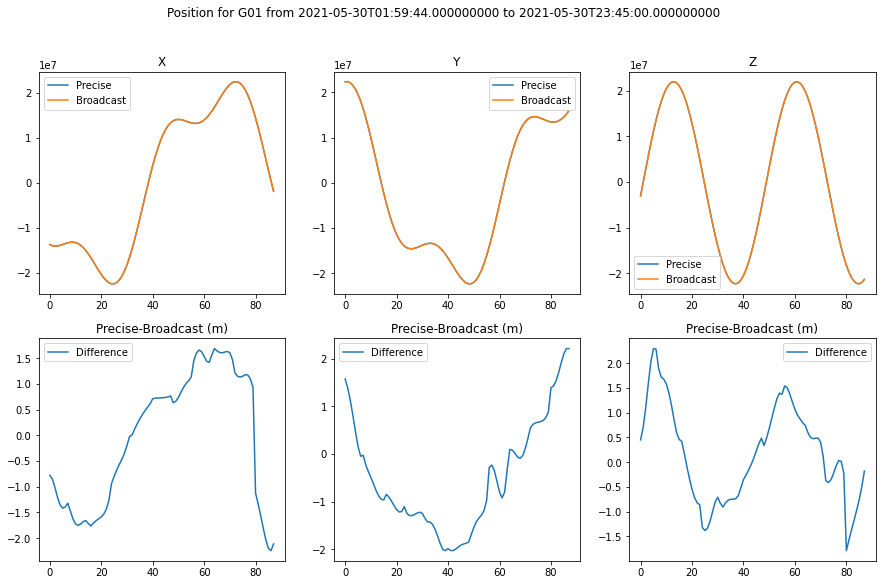

In [ ]:
fig, axs = plt.subplots(2,3,figsize=(15, 9))
fig.suptitle('Position for {} from {} to {}'.format(sv,t_begin.values,t_end.values))
axs[0][0].set_title('X')
axs[0][0].plot(sp3.sel(sv=sv).position.sel(ECEF='x')*1000,label="Precise")
axs[0][0].plot(brdSatPos.sel(sv=sv).X, label="Broadcast")
axs[0][0].legend()
axs[0][1].set_title('Y')
axs[0][1].plot(sp3.sel(sv=sv).position.sel(ECEF='y')*1000,label="Precise")
axs[0][1].plot(brdSatPos.sel(sv=sv).Y, label="Broadcast")
axs[0][1].legend()
axs[0][2].set_title('Z')
axs[0][2].plot(sp3.sel(sv=sv).position.sel(ECEF='z')*1000,label="Precise")
axs[0][2].plot(brdSatPos.sel(sv=sv).Z, label="Broadcast")
axs[0][2].legend()
axs[1][0].set_title('Precise-Broadcast (m)')
axs[1][0].plot(sp3.sel(sv=sv).position.sel(ECEF='x')*1000-brdSatPos.sel(sv=sv).X,label="Difference")
axs[1][0].legend()
axs[1][1].set_title('Precise-Broadcast (m)')
axs[1][1].plot(sp3.sel(sv=sv).position.sel(ECEF='y')*1000-brdSatPos.sel(sv=sv).Y,label="Difference")
axs[1][1].legend()
axs[1][2].set_title('Precise-Broadcast (m)')
axs[1][2].plot(sp3.sel(sv=sv).position.sel(ECEF='z')*1000-brdSatPos.sel(sv=sv).Z,label="Difference")
axs[1][2].legend()
plt.show()

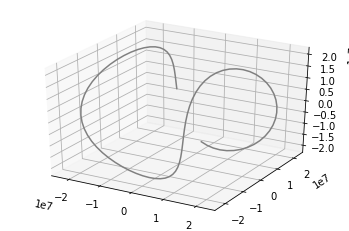

In [ ]:
#3D plot would only make sense in celestial coordinates
fig = plt.figure()
ax = plt.axes(projection='3d',label="Vehicle"+sv)
ax.plot([0],[0],[0],'go', label='Earth center') 
ax.plot3D(brdSatPos.sel(sv=sv).X, brdSatPos.sel(sv=sv).Y, brdSatPos.sel(sv=sv).Z, 'gray')
plt.show()

# Exercise 3: Keplerian Orbits from Position and Speed


In [ ]:
#r=sp3.position.sel(sv=sv)
#rdot=sp3.velocity.sel(sv=sv)
"""Georinex currently doesn't read sp3-a files as sent by NGA
*  2021  5 30  2  0  0.00000000
P  1 -13710.068285  22353.304398  -3044.860823    674.320859                    
V  1  -3968.108531   1533.756112  32198.198345     -0.114749   """


#CHANGE THIS
rvec=[-13710.068285,  22353.304398,  -3044.860823] 
sp3vec=[-3968.108531,   1533.756112,  32198.198345] 

In [ ]:
#positions are in km
rvec=np.array(rvec)*1000
#according to https://gssc.esa.int/wp-content/uploads/2018/07/sp3d.pdf the velocity is in decimeters/sec
sp3vec=np.array(sp3vec)*0.1

r=np.linalg.norm(rvec)
bGM84 =  3.986005e14 #This is default

## sp3 speed to orbit speed (confirm with Dr Haroldo)


In [ ]:
#Using x-y position vector because the earth rotation is on the z axis
r_xy=np.sqrt(rvec[0]**2+rvec[1]**2)
earthrate                =  7.2921151467e-5 #This is default bOMEGAE84
speed=r_xy*earthrate 
#Angle of the position on the x-y plane
theta=np.arcsin(rvec[1]/np.sqrt(rvec[1]**2+rvec[0]**2))
if rvec[0]<0:
  theta=np.pi-theta
print(theta)
print(theta/np.pi*180)
tangentAngle=np.pi/2+theta
earthRotVec=np.array([speed*cos(tangentAngle),speed*sin(tangentAngle),0])

rdotvec=sp3vec+earthRotVec

rdot=np.linalg.norm(rdotvec)
print("Velocity vector:",rdotvec)
print("Velocity norm:",rdot)

2.1209634590550475
121.52225470532241
Velocity vector: [-2026.83954889  -846.37835483  3219.8198345 ]
Velocity norm: 3897.6498871926683


In [ ]:
a=r*bGM84/(2*bGM84 - r * rdot*rdot)
print("Major axis:",a)
print("Major axis from navigation file: 26560425.7239707")
print("SqrtA",np.sqrt(a))

Major axis: 26561903.96815748
Major axis from navigation file: 26560425.7239707
SqrtA 5153.824208115511


In [ ]:
A=rdot**2-bGM84/r
B=(-rvec*rdotvec).sum()
print("A",A)
print("B", B)
evec=(A*rvec+B*rdotvec)/bGM84
print("Vector e",evec)
e=np.linalg.norm(evec)
print("e",e)
hvec=np.cross(rvec,rdotvec)
h=np.linalg.norm(hvec)
print("hvec",hvec) #angular momentum
print("hvec unit",hvec/h) #angular momentum
nvec=np.array([-hvec[1],hvec[0],np.zeros_like(hvec[1])])
n=np.linalg.norm(nvec)
nvec=nvec/n #normalizing
print("Vector n",nvec)
i=np.arccos(hvec[2]/h)
print("i:",i)
bigomega=np.arccos(nvec[0])
print("big Omega:",bigomega)
omega=arccos((nvec*evec).sum()/(n*e))
print("omega:",omega)
f=arccos((evec*rvec).sum()/(e*r))
print("f:",f)
u=omega+f #latitude argument
print("Latitude argument u:",u)
n0=np.sqrt(bGM84/a**3)
print("n0",n0)
P=2*np.pi/n0
print("P",P)
#This was not in the formulas. I'm assuming the time began when the sattelite crossed the perigee
deltat=f/n0 
print("deltaT:",deltat)
M=n0*deltat
#this is currently equal to f, so we're assuming instant speed equals average speed.
print("M:",M) 

A 92600.72230307199
B 935147654.574379
Vector e [-0.00794017  0.00320733  0.00684658]
e 0.01096398508201376
hvec [6.93965086e+10 5.03153941e+10 5.69104664e+10]
hvec unit [0.67447399 0.48902207 0.55312047]
Vector n [-0.58698994  0.80959422  0.        ]
i: 0.9846911222909013
big Omega: 2.19813214989057
omega: 1.5707963267871743
f: 0.9862927003309794
Latitude argument u: 2.5570890271181534
n0 0.0001458411621037332
P 43082.3864576073
deltaT: 6762.786898457747
M: 0.9862927003309794


## Expected results

Compare the results bellow with the kepplerian data found from sp3 coordinates.

In [ ]:
navData=nav.sel(sv="G01",time='2021-05-30T02:00:00.000000000')

In [ ]:
t=np.datetime64('2021-05-30T02:00:00.000000000')
def getSecsOfWeek(t):
    day=t.astype('datetime64[D]')
    secsOfDay=(t-day)/ np.timedelta64(1, 's')
    gps_t0=np.datetime64('1980-01-06T00:00:00')
    dayOfWeek=((t - gps_t0)/ np.timedelta64(1, 'D') % 7).astype(np.int64)
    return secsOfDay+dayOfWeek*24*60*60
    
t=getSecsOfWeek(t)
tk = t - navData.Toe;
omegak = navData.Omega0 + (navData.OmegaDot-earthrate)*tk - earthrate*navData.Toe;
print("Big omega:",omegak.values)
print("i:", navData.Io.values)

Big omega: 2.1981396851206
i: 0.9846459541591


In [ ]:
navData


<xarray.Dataset>
Dimensions:           ()
Coordinates:
    time              datetime64[ns] 2021-05-30T02:00:00
    sv                <U3 'G01'
Data variables: (12/29)
    SVclockBias       float64 0.0006743
    SVclockDrift      float64 -1.148e-11
    SVclockDriftRate  float64 0.0
    IODE              float64 30.0
    Crs               float64 -81.28
    DeltaN            float64 4.192e-09
    ...                ...
    SVacc             float64 2.4
    health            float64 0.0
    TGD               float64 5.122e-09
    IODC              float64 30.0
    TransTime         float64 30.0
    FitIntvl          float64 4.0
Attributes:
    version:    2.1
    svtype:     ['G']
    rinextype:  nav
    filename:   NGA_150a.21n

# Exercise 4 - Errors on the satellite reference system

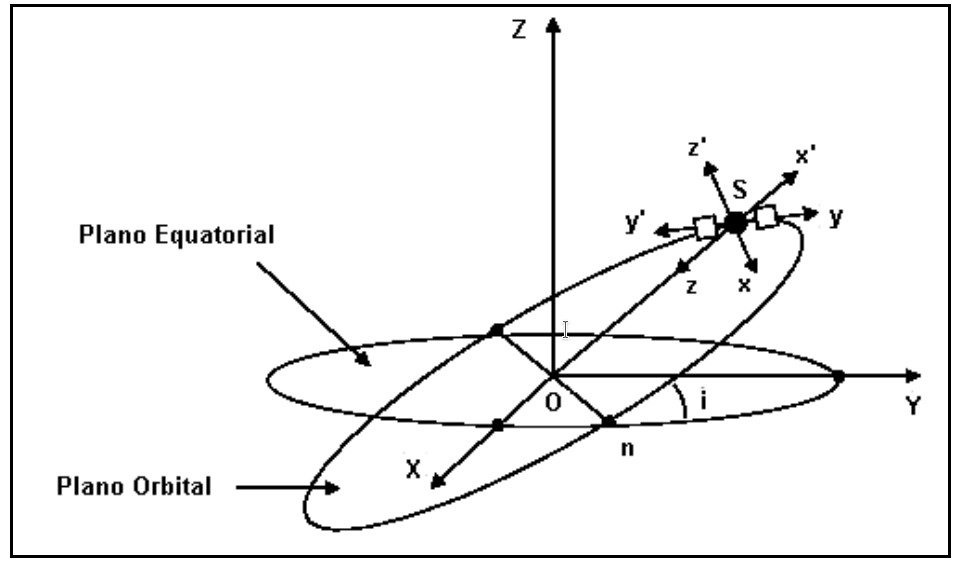

In [ ]:
#Rotation matrix
def R(theta,axis): 
  c=np.cos(theta)
  s=np.sin(theta)
  if axis==1: return np.array([[1,0,0],[0,c,s],[0,-s,c]])
  if axis==2: return np.array([[c,0,-s],[0,1,0],[s,0,c]])
  if axis==3: return np.array([[c,s,0],[-s,c,0],[0,0,1]])

In [ ]:
errors=np.array([0.36, 1.18, 2.65])
print("Errors in TCS: ", errors)
m=R(f+navData.omega,3) @ R(i,1) @ R(bigomega,3) 
print("Rotation matrix: ",m)
X2_scs=m @ errors
X_scs=X2_scs[[2,1,0]]*-1.
print("Errors in SCS:",X_scs)

Errors in TCS:  [0.36 1.18 2.65]
Rotation matrix:  [[-0.2776537  -0.52617613  0.80377055]
 [ 0.68410033 -0.69569827 -0.21911333]
 [ 0.67447399  0.48902207  0.55312047]]
Errors in SCS: [-2.28562592  1.15529816 -1.40914879]


In [ ]:
print("Norm of the error vector in TCS",np.linalg.norm(errors))
print("Norm of the error vector in SCS",np.linalg.norm(X_scs))

Norm of the error vector in TCS 2.923097671991136
Norm of the error vector in SCS 2.923097671991136


## Bonus: Errors with unit vectors

In [ ]:
r_unit=rvec/r
print("Unit vector on R direction:",r_unit)
n_unit=np.cross(rvec,rdotvec)
n=np.linalg.norm(n_unit)
n_unit=n_unit/n
print("Unit vector on N direction:",n_unit)
t_unit=np.cross(n_unit,r_unit)
t=np.linalg.norm(t_unit)
t_unit=t_unit/t
print("Unit vector on T direction:",t_unit)
m=np.stack([n_unit, t_unit, r_unit])
print("Rotation matrix:")
print(m)
errors=array([0.36, 1.18, 2.65])
errorsInSCS=m@errors
print("Errors in SCS:",errorsInSCS)


Unit vector on R direction: [-0.51934038  0.84674805 -0.11533999]
Unit vector on N direction: [0.67447399 0.48902207 0.55312047]
Unit vector on T direction: [-0.52475748 -0.20946397  0.82507844]
Rotation matrix:
[[ 0.67447399  0.48902207  0.55312047]
 [-0.52475748 -0.20946397  0.82507844]
 [-0.51934038  0.84674805 -0.11533999]]
Errors in SCS: [2.28562592 1.7503777  0.50654918]


In [ ]:
print("Norm of the error vector in TCS",np.linalg.norm(errors))
print("Norm of the error vector in SCS",np.linalg.norm(errorsInSCS))

Norm of the error vector in TCS 2.923097671991136
Norm of the error vector in SCS 2.923097671991136
